# Pronosticos de ventas de tienda online

## 1.Introducción

### 1.1. Descripcion del caso de negocio

En la actualidad, la empresa se encuentra inmersa en la planificación estratégica de sus próximas inversiones y operaciones. En este contexto, la comprensión profunda del comportamiento de las ventas y la capacidad de prever su dirección a corto y mediano plazo se erigen como elementos críticos. La obtención de datos precisos y relevantes se convierte, por lo tanto, es una prioridad estratégica para orientar la toma de decisiones de manera informada y eficaz. Este informe está diseñado para satisfacer las necesidades de los altos, el departamento de ventas y principalmente a los equipos de logística y distribución.

En este exhaustivo análisis, exploraremos el rendimiento de las ventas de productos durante los últimos cuatro años, resaltando las tendencias y patrones clave en las ventas. Nuestra intención es proponer modelos de predicción de ventas que permitan anticipar los futuros patrones y tendencias. Es importante señalar que la empresa opera en el mercado estadounidense y se especializa en la venta de mobiliario, suministros y accesorios tecnológicos para oficinas. Este enfoque sectorial nos brinda una visión detallada del comportamiento del mercado y nos permite ofrecer soluciones más precisas y adaptadas a las necesidades específicas de nuestros clientes en el ámbito empresarial.

Este estudio se concentra en generar un pronóstico de la cantidad de productos vendidos semanalmente y proyectar las ventas para las próximas 4 semanas a partir de la última fecha conocida. Esta información resulta de suma relevancia para la planificación logística y distribución de los productos. Por ejemplo, permite definir la capacidad de procesamiento en el almacén logístico y establecer la capacidad de contratación del agente distribuidor de última milla, entre otros aspectos cruciales. Con este enfoque predictivo, se busca optimizar la gestión de inventario y recursos, garantizando una distribución eficiente y oportuna de los productos, lo que a su vez potencia la satisfacción del cliente y la eficacia operativa de la empresa.


### 1.2. Objetivos y metodología

Nuestra principal meta es desarrollar un modelo predictivo capaz de estimar con precisión la cantidad de productos que se venderán. El conjunto de datos que emplearemos comprende información detallada sobre las ventas de los últimos cuatro años de una destacada compañía de comercio electrónico. Enfrentaremos este desafío como un problema de serie temporal, donde la fecha de la orden se presenta como la única variable de entrada, siendo la variable objetivo la cantidad de ítems que se comercializarán en un horizonte temporal de un mes, partiendo desde la última fecha registrada en el conjunto de datos.

## 2. Descripcion de los datos

Los datos se obtuvieron de la plataforma de Kaggle: 
    
    link: https://www.kaggle.com/datasets/rohitsahoo/sales-forecasting?datasetId=835308
    Dataset con transacción desde enero 2014 a diciembre de 2017, contiene 20 columnas y 9994 registros.
    
***Descripcion de los campos***
    
- **ID Orden:** Identificador unico para cada pedido realizado.
- **Fecha Orden:** Fecha en que se realizó el pedido
- **Fecha Envio:** Fecha de envio de los articulos pedidos       
- **Modo Envío:** Modo de envio elegido para el pedido (Second Class, Standard Class, First Class, Same Day)        
- **ID Cliente:** Identificacion unica para cada cliente
- **Nombre Cliente:** Nombre del cliente que realiza el pedido   
- **Segmento:** Segmento de mercado al que pertenece el cliente(Consumer, Corporate, Home Office)    
- **Pais:** Pais donde se realiza la compra (Estados Unidos)        
- **Ciudad:** Ciudad donde se realizó el pedido        
- **Estado:** Estado dentro del país donde se realiza el pedido   
- **Codigo Postal:** Codigo postal asociado a la ubicacion del pedido        
- **Region:** La region del pais donde se realizó el pedido (South, West, Central, East)   
- **ID Producto:** Identificador unico de cada producto        
- **Categoria:** Categoria amplia a la que pertenece el producto (Furniture, Office Supplies, Technology)       
- **Sub-Categoria:** Subcategoria especifica a la que pertenece el producto(Bookcases, Chairs, Labels, Tables, Storage,...)  
- **Nombre Producto:** Nombre del producto ordenado  
- **Monto Venta:** Monto de la venta en dolares       
- **Cantidad Items:** Cantidad de items de producto        
- **Descuento:** Porcentaje de descuento aplicada a la compra 
- **Ganancia:** Monto de ganancia de la compra en dolares       

In [87]:
# Procesamiento y manipulación
import pandas as pd
import numpy as np
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from datetime import datetime, timedelta
from sklearn.preprocessing import OneHotEncoder,MinMaxScaler

# Gráficos
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import plotly.express as px

# Modelado
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from pmdarima import auto_arima
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import ARIMA,auto_arima
from sklearn.model_selection import TimeSeriesSplit

# Métricas
from sklearn.metrics import r2_score, mean_absolute_percentage_error,mean_absolute_error,mean_squared_error
from prophet.diagnostics import performance_metrics
from sklearn import metrics
# Advertencias
import warnings
warnings.filterwarnings("ignore")

In [88]:
def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots(figsize=(12,4))
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Anual (1)",
            "Semianual (2)",
            "Cuatrimestral (4)",
            "Bimensual (6)",
            "Mensual (12)",
            "Bisemanal (26)",
            "Semanal (52)",
            "Semisemanal (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Varianza")
    ax.set_title("Periodograma de frecuencias")
    return ax

In [271]:
# Importación de datos
data=pd.read_csv('C:/Users/horac/Proyecto Data Science/Ventas_superstore.csv', encoding='latin-1', index_col='Row ID')
data['Fecha Orden'] = pd.to_datetime(data['Fecha Orden'])
data['Fecha Envio'] = pd.to_datetime(data['Fecha Envio'])
data['Precio']= data['Monto Venta']/data['Cantidad']
data.rename(columns={'Cantidad':'Cantidad Items'}, inplace=True)
data.head(3)

,ID Orden,Fecha Orden,Fecha Envio,Modo Envio,ID Cliente,Nombre Cliente,Segmento,Pais,Ciudad,Estado,...,Region,ID Producto,Categoria,Sub-Categoria,Nombre Producto,Monto Venta,Cantidad Items,Descuento,Ganancia,Precio
Row ID,,,,,,,,,,,,,,,,,,,,,
1,CA-2016-152156,2016-11-08,2016-11-11,Segunda Clase,CG-12520,Claire Gute,Consumidor,Estados Unidos,Henderson,Kentucky,...,Sur,FUR-BO-10001798,Muebles,Biblioteca,Bush Somerset Collection Bookcase,261.96,2,0.0,41.9136,130.98
2,CA-2016-152156,2016-11-08,2016-11-11,Segunda Clase,CG-12520,Claire Gute,Consumidor,Estados Unidos,Henderson,Kentucky,...,Sur,FUR-CH-10000454,Muebles,Sillas,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.94,3,0.0,219.5820,243.98
3,CA-2016-138688,2016-06-12,2016-06-16,Segunda Clase,DV-13045,Darrin Van Huff,Corporativo,Estados Unidos,Los Angeles,California,...,Oeste,OFF-LA-10000240,Insumos Oficina,Etiquetas,Self-Adhesive Address Labels for Typewriters b...,14.62,2,0.0,6.8714,7.31


## 3. Hipotesis y preguntas

Temporalidad de las ventas
- 1. ¿Cómo evolucionan las ventas a lo largo del tiempo?¿Pueden notarse patrones estacionales y de tendencia?
- 2. ¿Cuales son los periodos con mayor y menor volumen de ventas?
- 3. ¿Las ventas se ven afectadas por eventos externos, como eventos festivos u otros?
- 4. ¿Se pueden apreciar cambios abruptos o anomalias en el comportamiento de las ventas?
- 5. ¿Hay alguna relacion entre precios y cantidades vendidas?
- 6. ¿Cuál es la cantidad promedio de compra de productos?

## 4. Analisis exploratorio de los datos (EDA)

### 4.1. Valores faltantes

In [272]:
# Valores faltantes
data.info() # No hay valores nulos

<class 'pandas.core.frame.DataFrame'>
Index: 9994 entries, 1 to 9994
Data columns (total 21 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   ID Orden         9994 non-null   object        
 1   Fecha Orden      9994 non-null   datetime64[ns]
 2   Fecha Envio      9994 non-null   datetime64[ns]
 3   Modo Envio       9994 non-null   object        
 4   ID Cliente       9994 non-null   object        
 5   Nombre Cliente   9994 non-null   object        
 6   Segmento         9994 non-null   object        
 7   Pais             9994 non-null   object        
 8   Ciudad           9994 non-null   object        
 9   Estado           9994 non-null   object        
 10  Codigo Postal    9994 non-null   int64         
 11  Region           9994 non-null   object        
 12  ID Producto      9994 non-null   object        
 13  Categoria        9994 non-null   object        
 14  Sub-Categoria    9994 non-null   object      

### 4.2. Duplicados

In [273]:
# Duplicados
data[data.duplicated(keep=False)]

,ID Orden,Fecha Orden,Fecha Envio,Modo Envio,ID Cliente,Nombre Cliente,Segmento,Pais,Ciudad,Estado,...,Region,ID Producto,Categoria,Sub-Categoria,Nombre Producto,Monto Venta,Cantidad Items,Descuento,Ganancia,Precio
Row ID,,,,,,,,,,,,,,,,,,,,,
3406,US-2014-150119,2014-04-23,2014-04-27,Clase Estandar,LB-16795,Laurel Beltran,Oficina Particular,Estados Unidos,Columbus,Ohio,...,Este,FUR-CH-10002965,Muebles,Sillas,Global Leather Highback Executive Chair with P...,281.372,2,0.3,-12.0588,140.686
3407,US-2014-150119,2014-04-23,2014-04-27,Clase Estandar,LB-16795,Laurel Beltran,Oficina Particular,Estados Unidos,Columbus,Ohio,...,Este,FUR-CH-10002965,Muebles,Sillas,Global Leather Highback Executive Chair with P...,281.372,2,0.3,-12.0588,140.686


In [274]:
# Eliminacion de duplicados
data.drop_duplicates(inplace=True)
data[data.duplicated()].shape

(0, 21)

### 4.4. Gráficos

#### ¿Existe una relacion entre precio y cantidades vendidas? ¿Cual es la cantidad promedio de items por orden?
Si bien se observa una correlación no significativa entre los precios y las cantidades vendidas, es relevante destacar la composición frecuente de las órdenes de venta, compuestas por una moda de 3 articulos y una media de 8 items. Este patrón recurrente en el tamaño de las órdenes de compra ofrece información valiosa para optimizar los procesos internos de logística. La identificación de este número promedio de artículos por pedido puede ser clave para agilizar las operaciones de picking durante la preparación y despacho de los pedidos, permitiendo una gestión más eficiente de inventario y una distribución más ágil y precisa de los productos.

Text(0.5, 1.0, 'Precio vs Cantidad de Items')

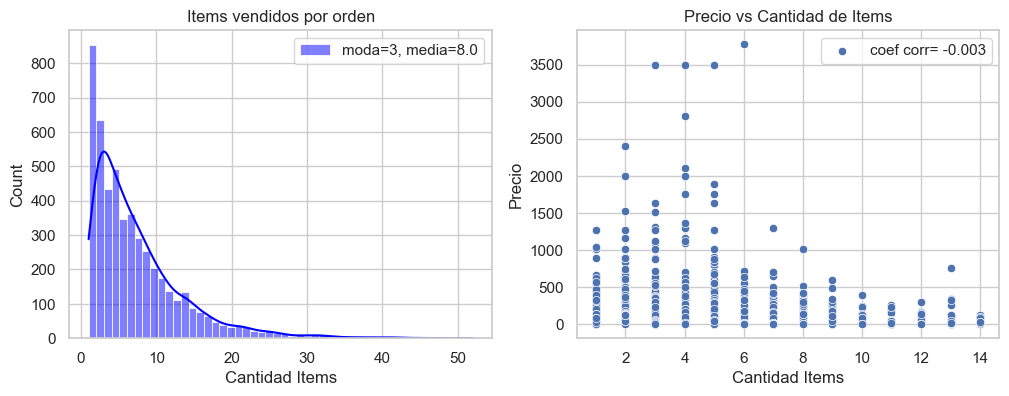

In [275]:
items=pd.DataFrame(data.groupby('ID Orden').agg({'Monto Venta':'sum','Cantidad Items':'sum'}))
matriz_corr=data[['Cantidad Items', 'Precio']].corr()
moda=items['Cantidad Items'].mode(1)[0]
media=items['Cantidad Items'].mean()

#histograma de distribucion de variables
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
sns.histplot(items['Cantidad Items'], kde=True, color='blue', bins=50, label=f'moda={moda}, media={round(media,0)}')
plt.legend()
plt.title('Items vendidos por orden')

plt.subplot(1,2,2)
sns.scatterplot(data=data, x='Cantidad Items', y='Precio',label=f'coef corr= {round(matriz_corr.iloc[1,0],3)}')
plt.title('Precio vs Cantidad de Items')


#### ¿Cómo evolucionan las ventas a lo largo del tiempo?¿Pueden notarse patrones estacionales y de tendencia?
En el análisis gráfico de las ventas desglosadas por día, semana, mes y año, se identifican patrones estacionales significativos. Los meses de noviembre y diciembre muestran un incremento notable en la cantidad de unidades vendidas, posiblemente asociado a las festividades de fin de año. Por otro lado, los primeros meses del año registran cifras más bajas en ventas. Además, al observar el gráfico de ventas anuales, se evidencia una tendencia general al alza a lo largo del tiempo. Este patrón de crecimiento continuo en las ventas anuales sugiere un desarrollo positivo y sostenido del negocio a lo largo de los años. Estos insights son cruciales para ajustar estrategias estacionales, anticipar la demanda y maximizar el rendimiento en períodos de mayor y menor actividad comercial.

El periodograma de frecuencias nos ofrece una guía para identificar las estacionalidades más marcadas en nuestra serie temporal. Esta herramienta resulta fundamental para desarrollar variables específicas que potencien la capacidad de nuestros modelos para capturar con mayor precisión los patrones estacionales presentes en los datos. En el mismo puede observarse fuertes componentes anuales y cuatrimestrales.

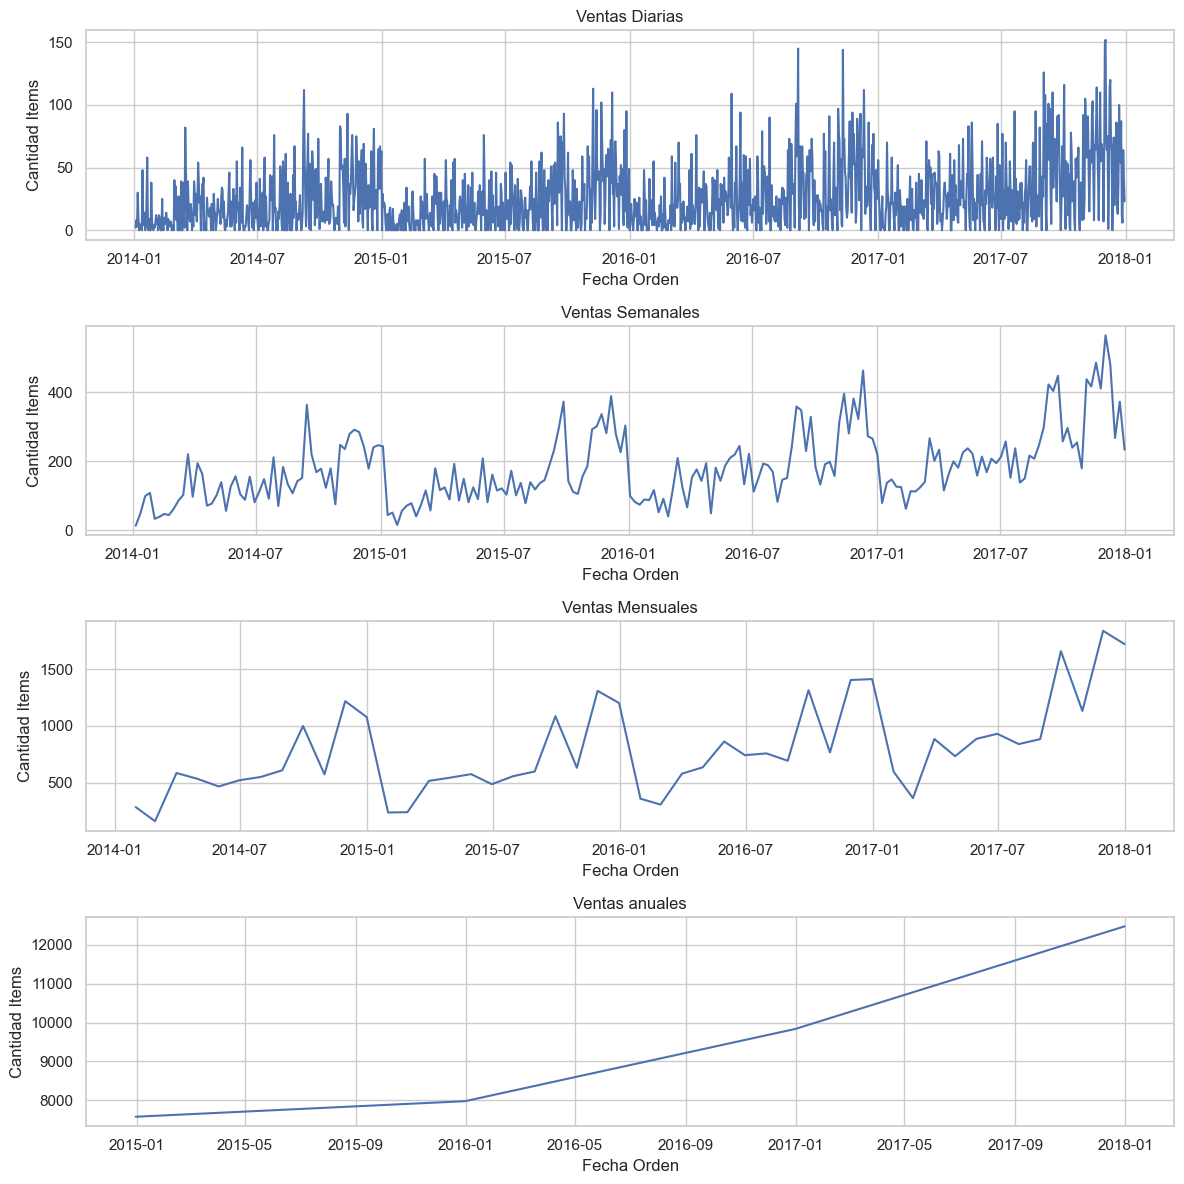

In [276]:
# Graficos ventas por fecha (varias granularidades)
target='Cantidad Items'
time_sales=pd.DataFrame(data.groupby(['Fecha Orden'])[target].sum())
time_sales=time_sales.asfreq("D")
time_sales.fillna(0, inplace=True)
ts=time_sales['Cantidad Items']
time_sales.reset_index(inplace=True)
ventas_sem=time_sales.resample('W', on='Fecha Orden').sum()
ventas_men=time_sales.resample('M', on='Fecha Orden').sum()
ventas_anu=time_sales.resample('A', on='Fecha Orden').sum()

fig,(ax1, ax2, ax3, ax4)=plt.subplots(4, figsize=(12,12))

sns.lineplot(x='Fecha Orden',y=target,data=time_sales, ax=ax1)
ax1.set_title('Ventas Diarias')

sns.lineplot(x='Fecha Orden',y=target,data=ventas_sem,ax=ax2)
ax2.set_title('Ventas Semanales')

sns.lineplot(x='Fecha Orden',y=target,data=ventas_men, ax=ax3)
ax3.set_title('Ventas Mensuales')

sns.lineplot(x='Fecha Orden',y=target,data=ventas_anu, ax=ax4)
ax4.set_title('Ventas anuales')

plt.tight_layout()

<Axes: title={'center': 'Periodograma de frecuencias'}, ylabel='Varianza'>

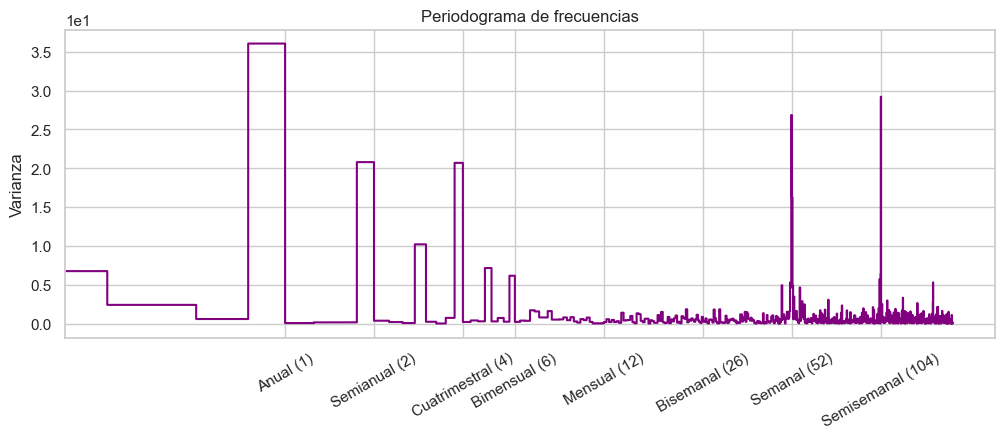

In [277]:
plot_periodogram(ts)

#### ¿Cuales son los periodos con mayor y menor volumen de ventas? ¿Las ventas se ven afectadas por eventos externos, como eventos festivos?
Tras un analisis exhaustivo de los datos temporales a nivel semanal, hemos optado por esta granularidad para realizar el pronostico de ventas, una medida que se alinea con la resolucion del problema de negocio planteado.
los graficos de barras que representan las ventas por semana a lo largo del año revelan patrones importante. Se destacan los aumentos significativos en las ventas entre las semanas 34 y 40, seguidos por una leve disminucion, para luego experimentar un repunte en las semanas finales del año. Este comportamiento parece estar muy ligado a las festividades de fin de año.
Sin embargo, al explorar las ventas por semana dentro de cada mes, no se distingue un patron significativo. Esto sugiere que, si bien las ventas muestran una marcada estacionalidad en ciertas semanas del año, esta tendencia no se replica en el analisis de ventas por semana del mes. En los siguientes analisis incorporaremos los eventos festivos y volveremos sobre la pregunta de las influencias de eventos externos.

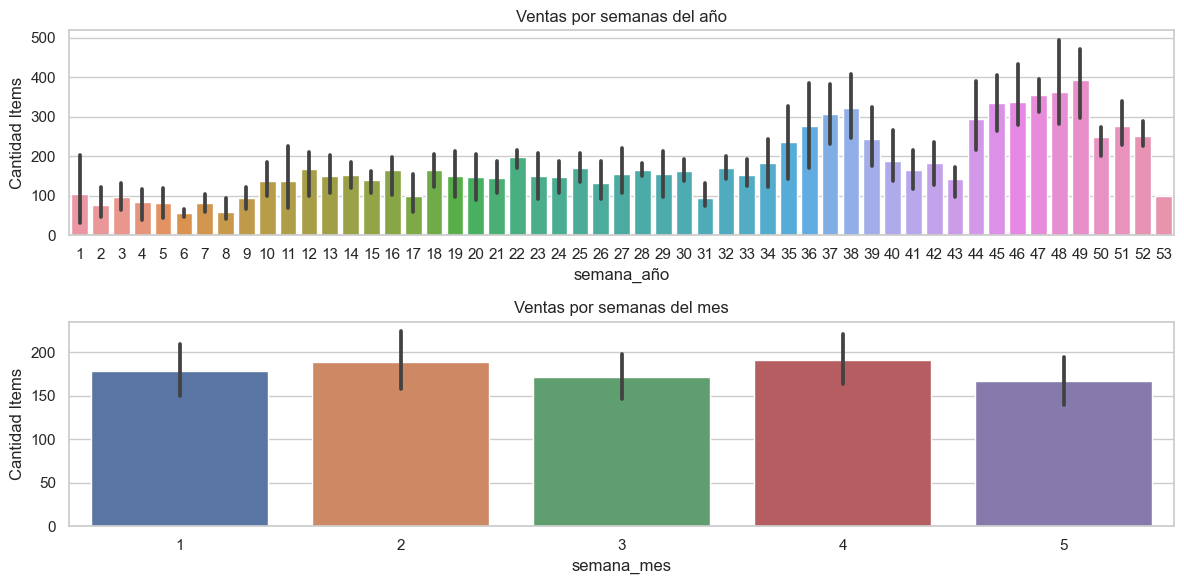

In [278]:
ventas_sem['semana_año']=ventas_sem.index.isocalendar().week
ventas_sem['semana_mes']=(ventas_sem.index.day-1)//7+1

fig,(ax1, ax2)=plt.subplots(2, figsize=(12,6))

sns.barplot(x='semana_año',y='Cantidad Items',data=ventas_sem, ax=ax1)
ax1.set_title('Ventas por semanas del año')

sns.barplot(x='semana_mes',y='Cantidad Items',data=ventas_sem,ax=ax2)
ax2.set_title('Ventas por semanas del mes')
plt.tight_layout()

#### ¿Se pueden apreciar cambios abruptos o anomalias en el comportamiento de las ventas?
Al examinar la serie temporal a grandes rasgos en busca de cambios bruscos o anomalias en el comportamiento de las ventas, hemos realizado la descomposicion de la serie. No se observan puntos destacados que sobresalgan de un comportamiento considerado"normal" de la serie temporal. Los residuos obtenidos tras la descomposicion se concentran alrededor de una media cero, lo que sugiere que no hay patrones sistematicos o tendencias persistentes que difieran de lo esperado. Los valores muestran consistencia y repeticion en su distribución a lo largo del tiempo. No se identifican cambios abruptos ni anomalias evidentes que puedan considerarse atipicas dentro del contexto de la serie temporal.

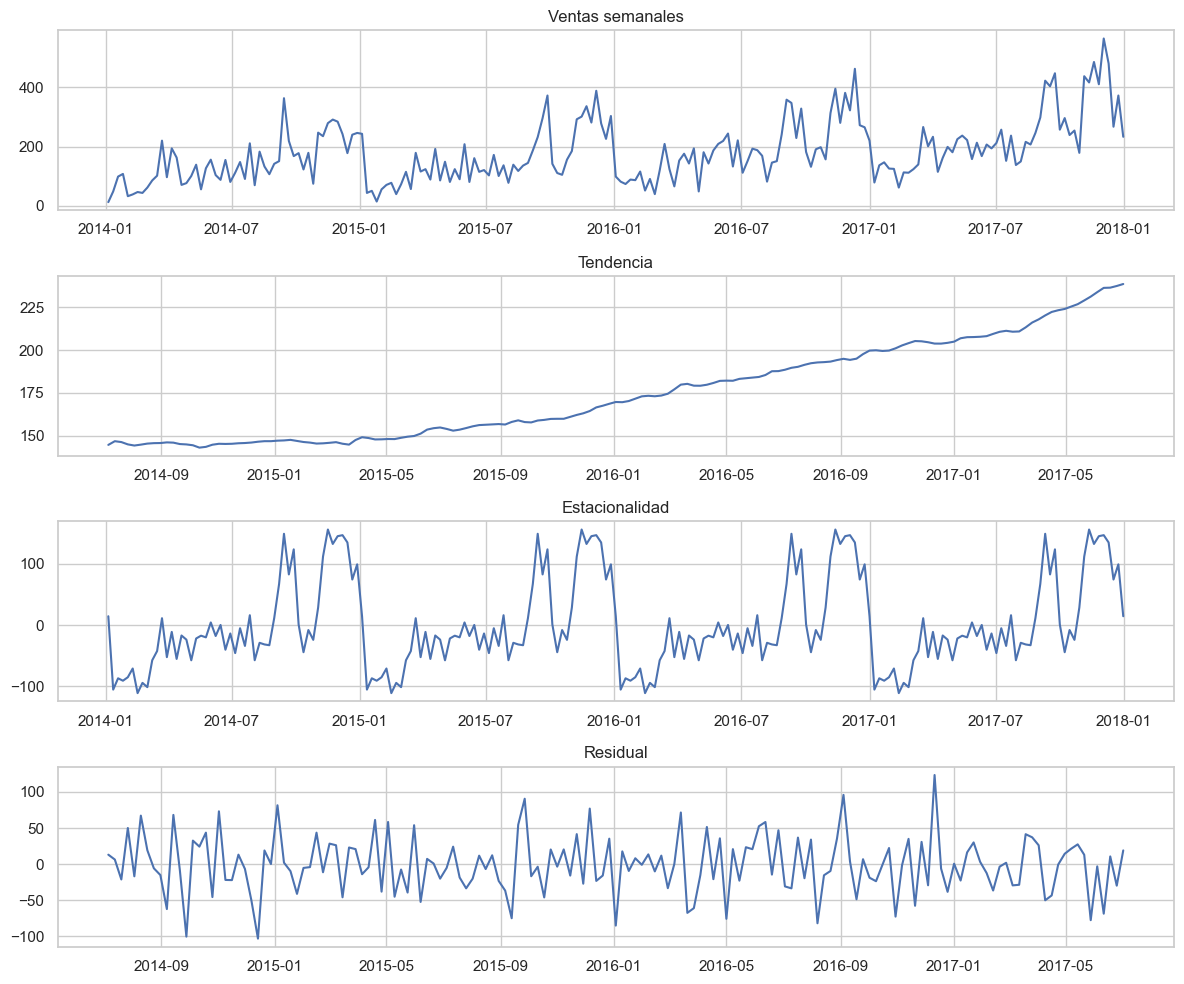

In [279]:
# Descomposición estacional de la serie de tiempo - mensual
result=sm.tsa.seasonal_decompose(ventas_sem[target],model='additive')

plt.figure(figsize=(12,10))
plt.subplot(411)
plt.plot(ventas_sem[target])
plt.title('Ventas semanales')
plt.grid(True)

plt.subplot(412)
plt.plot(result.trend)
plt.title('Tendencia')
plt.grid(True)

plt.subplot(413)
plt.plot(result.seasonal)
plt.title('Estacionalidad')
plt.grid(True)

plt.subplot(414)
plt.plot(result.resid)
plt.title('Residual')
plt.grid(True)
plt.tight_layout()

## 5. Ingenieria de atributos

El proceso de desarrollo de variables la llevaremos a cabo durante el modelado de cada tipo de modelo, considerando las particularidades de sus estructuras y tipos de datos. Durante este proceso, nos enfocaremos en la creacion de variables especificas que potencien la capacidad predictiva de los modelos. Esto implica inclusion de variables autorregresivas que capuren la dependencia de los datos en períodos anteriores, la implementacion de funciones de retraso que reflejen patrones termporales pasados, la consideracion de medias moviles que capturen la tendencia y la integracion de datos relacionados con dias festivos que pueden tener un impacto en el comportamiento de la serie temporal. Ademas exploraremos el uso de variables deterministicas, como los terminos de fourier, para representar estacionalidades recurrente en los datos.

Nuestra variable objetivo seran la cantidad de items vendidos por semana, el analisis lo realizaremos con una granularidad semanal de los datos.

In [280]:
# Serie temporal
df=ventas_sem.copy()
df.drop(columns={'semana_mes','semana_año'},inplace=True)
df.head(1)

,Cantidad Items
Fecha Orden,
2014-01-05,13.0


In [281]:
#Separacion Train (80%) - Test(20%)
size=int(round(df.shape[0]*0.2,0))
train,test=df[:-size],df[-size:]

# Definicion de features y target
f_train=train.drop(columns={'Cantidad Items'}) #subconjunto de entrenamiento - features
t_train=train['Cantidad Items'] # subconjunto de entrenamiento - target
f_test=test.drop(columns={'Cantidad Items'}) # subconjunto de testeo - features
t_test=test['Cantidad Items']  # subconjunto de testeo - target

fecha_inicial=f_train.index[0]
fecha_final=f_train.index[-1]

In [282]:
# definimos un dataframe que registre las metricas de los modelos mejorados
modelos=['Linear','Exponencial','Prophet','ARIMA','RandomForest']
indice=['MAPE','MAE','RMSE']
metricas=pd.DataFrame(columns=modelos, index=indice)

## 6. Algoritmos

Para garantizar una evaluación coherente y comparativa entre todos los modelos analizados, llevaremos a cabo el proceso de validacion cruzada utilizando la misma metodologia para cada uno de ellos. Esto es crucial ya que algunos modelos pueden no contar con la funcion de validacion cruzada incorporada. El objetivo es asegurar que la comparaciones entre los desempeños de los modelos sean compatibles y justas.

### 6.1. Regresion Lineal

In [283]:
# incorporacion de variables deterministicas
dp = DeterministicProcess(
    index=t_train.index,
    constant=False,
    order=2,
    seasonal=True,
    drop=True
    )
X_train_dp = dp.in_sample()
X_test_dp  = dp.out_of_sample(steps=size,forecast_index=t_test.index)

df_train=pd.concat([f_train,X_train_dp],axis=1)
df_test=pd.concat([f_test,X_test_dp], axis=1)


MAPE promedio: 0.26
MAE promedio: 46.39
RMSE promedio: 61.58


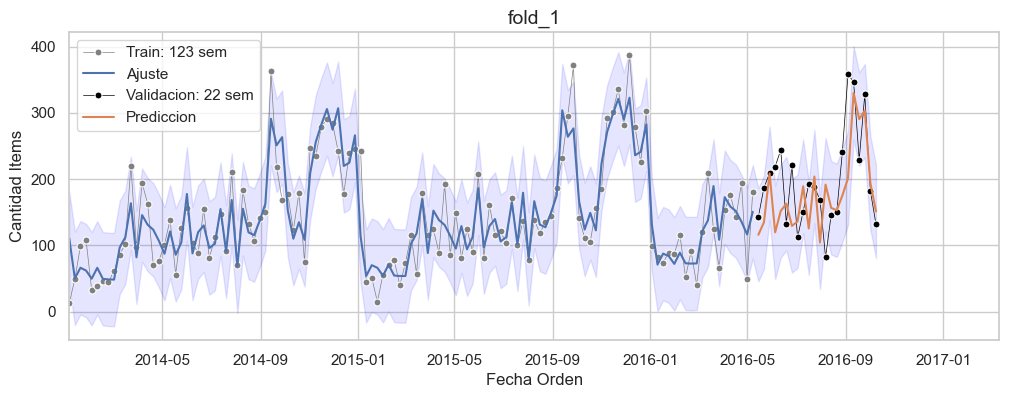

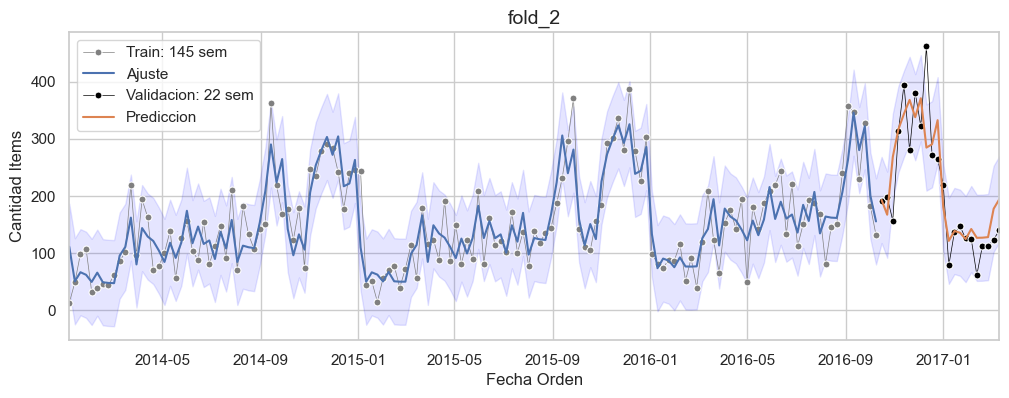

In [285]:
#Variables
tscv=TimeSeriesSplit(n_splits=2, test_size=22) # definimos las particiones (fold=3) del conjunto de validación
metric_1=[]
metric_2=[]
metric_3=[]
i=0
for tra, val in tscv.split(f_train):
    # Entrenamiento y validacion
    X_train, X_val=df_train.iloc[tra],df_train.iloc[val]
    y_train, y_val=t_train.iloc[tra],t_train.iloc[val]
    # Modelado y predicción
    model=LinearRegression().fit(X_train,y_train)
    y_pred=pd.Series(model.predict(X_val), index=X_val.index)
    y_ajus=pd.Series(model.predict(X_train), index=X_train.index)
    serie_ajus=pd.concat([y_ajus,y_pred])
    # calculamos la desviacion estandar de los residuos
    int_infer=serie_ajus-np.std(y_train-pd.concat([y_ajus,y_pred]))*1.96 # Intervalo de confianza de 0.95, z-score=1.96
    int_sup=serie_ajus+np.std(y_train-pd.concat([y_ajus,y_pred]))*1.96 
    
    #metricas
    MAPE= mean_absolute_percentage_error(y_val, y_pred)
    MAE=mean_absolute_error(y_val, y_pred)
    RMSE=np.sqrt(metrics.mean_squared_error(y_val, y_pred))
    R2=r2_score(y_val, y_pred)
    metric_1.append(MAPE)
    metric_2.append(MAE)
    metric_3.append(RMSE)
    i=i+1
    #graficos
    plt.figure(figsize=(12,4))
    sns.lineplot(x=y_train.index,y=y_train, data=y_train, label=f'Train: {y_train.shape[0]} sem',color='gray', marker='o', markersize=5, linewidth='0.5')
    sns.lineplot(x=y_ajus.index,y=y_ajus, data=y_ajus, label='Ajuste')
    sns.lineplot(x=y_val.index, y=y_val, data=y_val,label=f'Validacion: {y_val.shape[0]} sem',color='black', marker='o', markersize=5, linewidth='0.5')
    sns.lineplot(x=y_pred.index, y=y_pred, data=y_pred, label='Prediccion')
    plt.fill_between(serie_ajus.index,int_infer, int_sup, color='blue', alpha=0.1)
    plt.xlim(fecha_inicial, fecha_final)
    plt.title(f'fold_{i}', fontsize=14)


MAPE_prom=sum(metric_1)/len(metric_1)
MAE_prom=sum(metric_2)/len(metric_2)
RMSE_prom=sum(metric_3)/len(metric_3)
metricas.loc['MAPE','Linear']=MAPE_prom
metricas.loc['MAE','Linear']=MAE_prom
metricas.loc['RMSE','Linear']=RMSE_prom

print(f'MAPE promedio: {round(MAPE_prom,2)}')
print(f'MAE promedio: {round(MAE_prom,2)}')
print(f'RMSE promedio: {round(RMSE_prom,2)}')

### 6.2. Suavizado exponencial

MAPE promedio: 0.23
MAE promedio: 44.29
RMSE promedio: 61.4


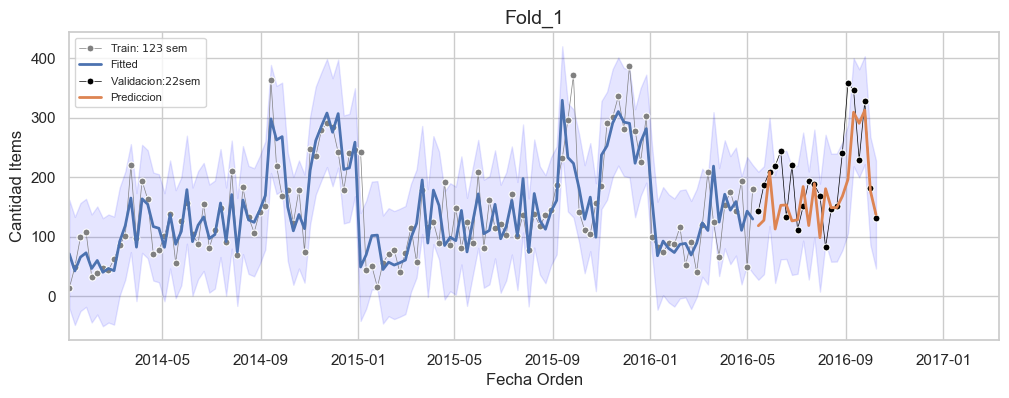

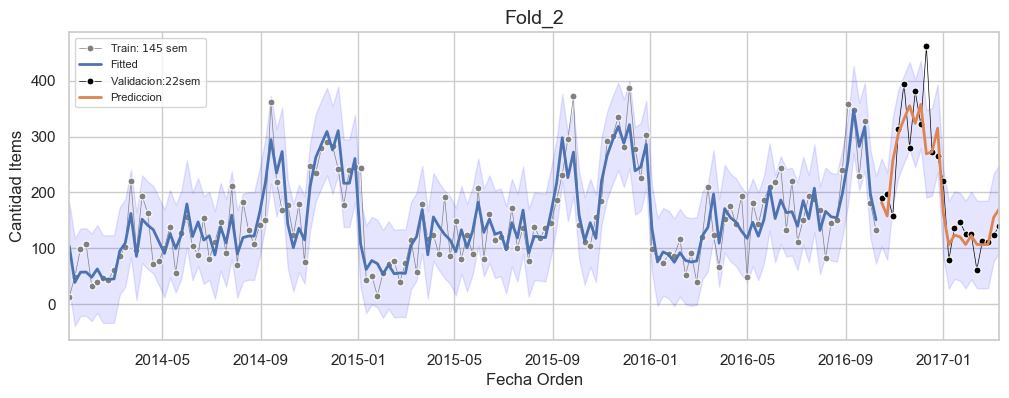

In [286]:
# continuamos con los mismos conjuntos de validacion y entrenamiento definidos para el modelo anterior
metric_1=[]
metric_2=[]
metric_3=[]
i=0

for tra, val in tscv.split(t_train):
        # datos de entrenamiento y validación
        y_train,y_val=t_train[tra],t_train[val]
        # Modelado
        modelo = ExponentialSmoothing(y_train,seasonal_periods=52,trend='add',
                                seasonal='add').fit(optimized=True,smoothing_level=0.085)
        y_ajus=modelo.fittedvalues
        y_pred=modelo.forecast(len(val))
        serie_ajus=pd.concat([y_ajus,y_pred])
        # calculamos la desviacion estandar de los residuos
        int_infer=serie_ajus-np.std(y_train-pd.concat([y_ajus,y_pred]))*1.96 # Intervalo de confianza de 0.95, z-score=1.96
        int_sup=serie_ajus+np.std(y_train-pd.concat([y_ajus,y_pred]))*1.96 
        # Metricas
        MAPE= mean_absolute_percentage_error(y_val, y_pred)
        MAE=mean_absolute_error(y_val, y_pred)
        RMSE=np.sqrt(mean_squared_error(y_val, y_pred))
        R2=r2_score(y_val, y_pred)
        metric_1.append(MAPE)
        metric_2.append(MAE)
        metric_3.append(RMSE)
        i=i+1
        
        
        plt.figure(figsize=(12,4))
        sns.lineplot(x=y_train.index, y=y_train , data=y_train, label=f'Train: ${y_train.shape[0]}$ sem',color='gray', marker='o', markersize=5, linewidth='0.5')
        sns.lineplot(x=y_ajus.index, y=y_ajus , data=y_ajus, label='Fitted',linewidth='2')
        sns.lineplot(x=y_val.index, y=y_val , data=y_val, label=f'Validacion:${y_val.shape[0]}$sem',color='black', marker='o', markersize=5, linewidth='0.5')
        sns.lineplot(x=y_pred.index, y=y_pred , data=y_pred, label='Prediccion',linewidth='2')
        plt.fill_between(serie_ajus.index,int_infer, int_sup, color='blue', alpha=0.1)
        plt.xlim(fecha_inicial, fecha_final)
        plt.title(f'Fold_{i}', fontsize=14)
        plt.legend(fontsize=8)
        plt.grid(True)
        
MAPE_prom=sum(metric_1)/len(metric_1)
MAE_prom=sum(metric_2)/len(metric_2)
RMSE_prom=sum(metric_3)/len(metric_3)
print(f'MAPE promedio: {round(MAPE_prom,2)}')
print(f'MAE promedio: {round(MAE_prom,2)}')
print(f'RMSE promedio: {round(RMSE_prom,2)}')

#### 6.2.3 Ajuste de hiperparametros

In [144]:
y_train=t_train[tra]
y_val=t_train[val]

In [213]:
seasonal=['mul','add']
trends=['mul','add']
smoothing_levels=[0.01,0.05,0.1,0.5,1]
smoothing_trends=[0.01,0.05,0.1,0.5,1]
mej_rmse=1000000000000000000000000.000
mej_param={}
medic=pd.Series()
contad=0
i=0
for seasonal in seasonal:
    for trend in trends:
        for smoothing_lev in smoothing_levels:
            for smoothing_tre in smoothing_trends:
                for tra, val in tscv.split(t_train):
                    # datos de entrenamiento y validación
                    y_train,y_val=t_train[tra],t_train[val]
                    es_model = ExponentialSmoothing(endog=y_train,
                                                    trend=trend,
                                                    seasonal=seasonal,
                                                    seasonal_periods=52,
                                                    ).fit(optimized=True,
                                                          smoothing_level=smoothing_lev,
                                                          smoothing_trend=smoothing_tre,
                                                         )
                    y_pred=es_model.forecast(len(y_val))
                    RMSE=np.sqrt(mean_squared_error(y_val, y_pred))
                    #print(y_train.shape,RMSE,seasonal,trend,smoothing_lev)
                    medic[i]=RMSE
                    i=i+1
                if medic.mean()<mej_rmse:
                    mej_rmse=medic.mean()
                    mej_param={'seasonal':seasonal, 'trend':trend,'smoothing_levels':smoothing_lev, 'smoothing_trends':smoothing_tre}
                medic=pd.Series()
                i=0
print(mej_param,mej_rmse)

{'seasonal': 'add', 'trend': 'mul', 'smoothing_levels': 0.01, 'smoothing_trends': 1} 59.840360728002196


#### 6.2.4 Modelo definitivo Suavizado Exponencial

In [288]:
# Reentrenamos y validamos con los nuevos hiperparametros
metric_1=[]
metric_2=[]
metric_3=[]
for tra, val in tscv.split(t_train):
        # datos de entrenamiento y validación
        y_train,y_val=t_train[tra],t_train[val]
        # Modelado
        modelo = ExponentialSmoothing(y_train,seasonal_periods=52,trend='mul',seasonal='add'
                                     ).fit(optimized=True,smoothing_level=0.01,smoothing_trend=1)              
        y_pred=modelo.forecast(len(val))
        # Metricas
        MAPE= mean_absolute_percentage_error(y_val, y_pred)
        MAE=mean_absolute_error(y_val, y_pred)
        RMSE=np.sqrt(mean_squared_error(y_val, y_pred))
        metric_1.append(MAPE)
        metric_2.append(MAE)
        metric_3.append(RMSE)
metricas.loc['MAPE','Exponencial']=MAPE_prom
metricas.loc['MAE','Exponencial']=MAE_prom
metricas.loc['RMSE','Exponencial']=RMSE_prom

MAPE_prom=sum(metric_1)/len(metric_1)
MAE_prom=sum(metric_2)/len(metric_2)
RMSE_prom=sum(metric_3)/len(metric_3)
print(f'MAPE promedio: {round(MAPE_prom,2)}')
print(f'MAE promedio: {round(MAE_prom,2)}')
print(f'RMSE promedio: {round(RMSE_prom,2)}')

MAPE promedio: 0.27
MAE promedio: 46.91
RMSE promedio: 59.84


### 6.3. Prophet

00:34:54 - cmdstanpy - INFO - Chain [1] start processing
00:34:54 - cmdstanpy - INFO - Chain [1] done processing
00:34:55 - cmdstanpy - INFO - Chain [1] start processing
00:34:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE promedio: 0.23
MAE promedio: 44.29
RMSE promedio: 56.45


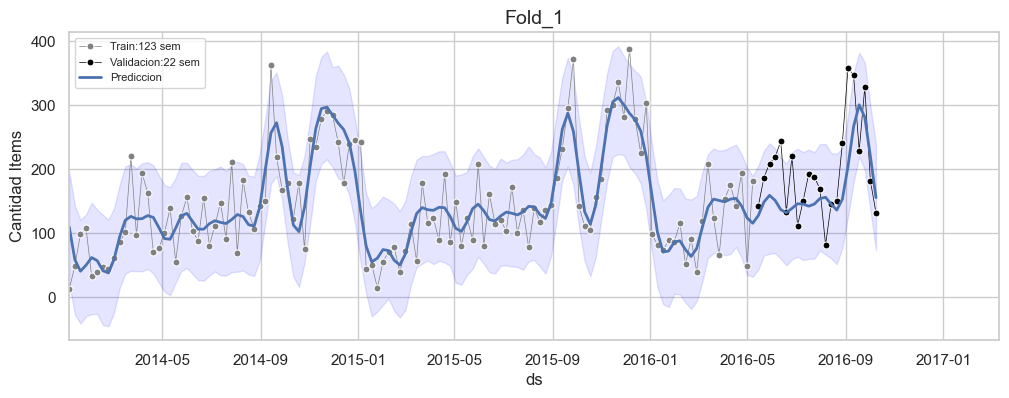

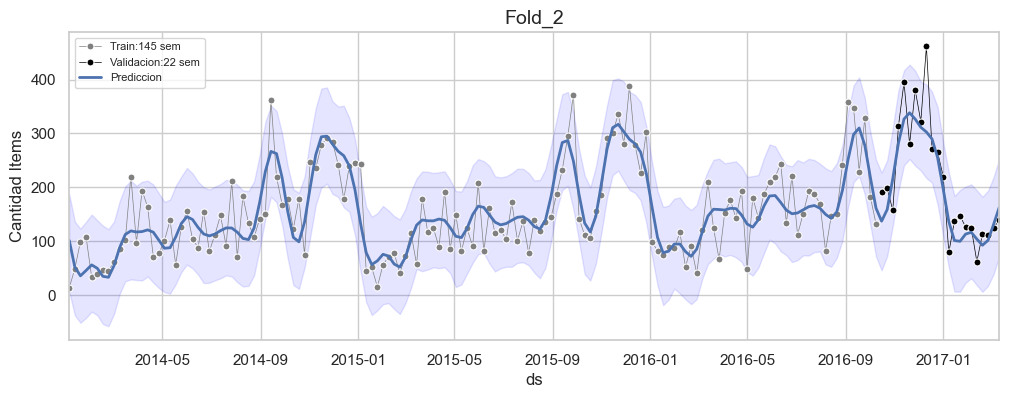

In [289]:
# Adecuacion de los datos para entrenamiento
df=ventas_sem.reset_index()
df.drop(columns={'semana_año','semana_mes'},inplace=True)
df=df.rename(columns={'Fecha Orden':'ds', 'Cantidad Items':'y'})
#Separacion Train (80%) - Test(20%)
df_trainval,df_test=df[:-size],df[-size:] #Dividimos los datos de entrenamiento y validacion de los datos de test.

metric_1=[]
metric_2=[]
metric_3=[]
i=0
for tra, val in tscv.split(df_trainval):
    #
    df_train,df_val=df_trainval.iloc[tra],df_trainval.iloc[val]
    
    m=Prophet(interval_width=0.95)
    
    m.fit(df_train)

    future=m.make_future_dataframe(periods=(len(val)), freq='W')
    forecast=m.predict(future)
    y_pred=forecast.iloc[-len(val):][['ds','yhat']]
    y_ajus=forecast.iloc[:-len(val)][['ds','yhat']]
    # Metricas
    MAPE= metrics.mean_absolute_percentage_error(df_val['y'], y_pred['yhat'])
    MAE=metrics.mean_absolute_error(df_val['y'], y_pred['yhat'])
    RMSE=np.sqrt(metrics.mean_squared_error(df_val['y'], y_pred['yhat']))

    metric_1.append(MAPE)
    metric_2.append(MAE)
    metric_3.append(RMSE)


    i=i+1
    
    plt.figure(figsize=(12,4))
    sns.lineplot(x='ds', y='y', data=df_train, label=f'Train:{df_train.shape[0]} sem',color='gray', marker='o', markersize=5, linewidth='0.5')
    sns.lineplot(x='ds', y='y', data=df_val, label=f'Validacion:{df_val.shape[0]} sem',color='black', marker='o', markersize=5, linewidth='0.5')
    sns.lineplot(x='ds', y='yhat', data=forecast, label='Prediccion',linewidth='2')
    plt.fill_between(forecast['ds'],forecast['yhat_lower'],forecast['yhat_upper'], color='blue', alpha=0.1)
    plt.title(f'Fold_{i}',fontsize=14)
    plt.ylabel('Cantidad Items')
    plt.xlim(fecha_inicial, fecha_final)
    plt.legend(fontsize=8)
    plt.grid(True)

MAPE_prom=sum(metric_1)/len(metric_1)
MAE_prom=sum(metric_2)/len(metric_2)
RMSE_prom=sum(metric_3)/len(metric_3)


print(f'MAPE promedio: {round(MAPE_prom,2)}')
print(f'MAE promedio: {round(MAE_prom,2)}')
print(f'RMSE promedio: {round(RMSE_prom,2)}')


#### 6.3.2 Ajuste de hiperparametros

In [262]:
# ajuste de hiperparametros
cutoffs=pd.to_datetime(['2016-05-15','2016-08-14'])
import itertools
import numpy as np
import pandas as pd

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'yearly_seasonality':[7,10,15],
    'changepoint_range':[0.8],
          'changepoint_prior_scale':[0.5],
          'seasonality_mode' : ['additive','multiplicative'],
          'n_changepoints':[1]
}

# generamos las combinaciones de parametros
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # definimos una lista para las metricas

# Evaluamos los hiperparametros
for params in all_params:
    m = Prophet(**params)
    m.add_country_holidays(country_name='US') # incorporando los dias festivos de estados unidos
    m.add_seasonality(name='mensual', period=4.5, fourier_order=17)
    m.add_seasonality(name='cuatrimestral', period=13, fourier_order=1)
    m.fit(df_trainval) 
    df_cv = cross_validation(m, cutoffs=cutoffs, horizon='22 w', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# 
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

00:26:03 - cmdstanpy - INFO - Chain [1] start processing
00:26:03 - cmdstanpy - INFO - Chain [1] done processing
00:26:06 - cmdstanpy - INFO - Chain [1] start processing
00:26:06 - cmdstanpy - INFO - Chain [1] done processing
00:26:06 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:26:06 - cmdstanpy - INFO - Chain [1] start processing
00:26:06 - cmdstanpy - INFO - Chain [1] done processing
00:26:09 - cmdstanpy - INFO - Chain [1] start processing
00:26:09 - cmdstanpy - INFO - Chain [1] done processing
00:26:09 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
00:26:09 - cmdstanpy - INFO - Chain [1] start processing
00:26:09 - cmdstanpy - INFO - Chain [1] done processing
00:26:12 - cmdstanpy - INFO - Chain [1] start processing
00:26:12 - cmdstanpy - INFO - Chain [1] done processing
00:26:12 -

    changepoint_prior_scale  seasonality_prior_scale  yearly_seasonality   
0                       0.5                     0.01                   7  \
1                       0.5                     0.01                   7   
2                       0.5                     0.01                  10   
3                       0.5                     0.01                  10   
4                       0.5                     0.01                  15   
5                       0.5                     0.01                  15   
6                       0.5                     0.10                   7   
7                       0.5                     0.10                   7   
8                       0.5                     0.10                  10   
9                       0.5                     0.10                  10   
10                      0.5                     0.10                  15   
11                      0.5                     0.10                  15   
12          

In [260]:
# Mejores hiperparametros
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'yearly_seasonality': 7, 'changepoint_range': 0.8, 'seasonality_mode': 'multiplicative', 'n_changepoints': 1}


#### 6.3.3 Modelo Prophet ajustado

In [387]:
# Adecuacion de los datos para entrenamiento
df=ventas_sem.reset_index()
df.drop(columns={'semana_año','semana_mes'},inplace=True)
df=df.rename(columns={'Fecha Orden':'ds', 'Cantidad Items':'y'})
#Separacion Train (80%) - Test(20%)
df_trainval,df_test=df[:-size],df[-size:] #Dividimos los datos de entrenamiento y validacion de los datos de test.

metric_1=[]
metric_2=[]
metric_3=[]
i=0
for tra, val in tscv.split(df_trainval):
    df_train,df_val=df_trainval.iloc[tra],df_trainval.iloc[val]
    m=Prophet(weekly_seasonality=False,
          daily_seasonality=False,
          yearly_seasonality=6,
          changepoint_range=0.8,
          changepoint_prior_scale=0.5,
          seasonality_mode = 'multiplicative',
          seasonality_prior_scale= 0.1,
          n_changepoints=1)
    m.add_country_holidays(country_name='US')
    m.add_seasonality(name='mensual', period=4.5, fourier_order=17)
    m.add_seasonality(name='cuatrimestral', period=13, fourier_order=1)

    m.fit(df_train)

    future=m.make_future_dataframe(periods=(len(val)), freq='W')
    forecast=m.predict(future)
    y_pred=forecast.iloc[-len(val):][['ds','yhat']]
    # Metricas
    MAPE= metrics.mean_absolute_percentage_error(df_val['y'], y_pred['yhat'])
    MAE=metrics.mean_absolute_error(df_val['y'], y_pred['yhat'])
    RMSE=np.sqrt(metrics.mean_squared_error(df_val['y'], y_pred['yhat']))
    metric_1.append(MAPE)
    metric_2.append(MAE)
    metric_3.append(RMSE)

MAPE_prom=sum(metric_1)/len(metric_1)
MAE_prom=sum(metric_2)/len(metric_2)
RMSE_prom=sum(metric_3)/len(metric_3)
metricas.loc['MAPE','Prophet']=MAPE_prom
metricas.loc['MAE','Prophet']=MAE_prom
metricas.loc['RMSE','Prophet']=RMSE_prom

print(f'MAPE promedio: {round(MAPE_prom,2)}')
print(f'MAE promedio: {round(MAE_prom,2)}')
print(f'RMSE promedio: {round(RMSE_prom,2)}')

11:49:49 - cmdstanpy - INFO - Chain [1] start processing
11:49:49 - cmdstanpy - INFO - Chain [1] done processing
11:49:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:49:49 - cmdstanpy - INFO - Chain [1] start processing
11:49:49 - cmdstanpy - INFO - Chain [1] done processing
11:49:49 - cmdstanpy - INFO - Chain [1] start processing
11:49:49 - cmdstanpy - INFO - Chain [1] done processing
11:49:49 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
11:49:49 - cmdstanpy - INFO - Chain [1] start processing
11:49:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE promedio: 0.25
MAE promedio: 45.64
RMSE promedio: 54.39


### 6.4. ARIMA

El modelo Arima requiere que la serie temporal sea estacionaria(propiedades estadisticas constantes en el tiempo), en el siguiente paso realizaremos la prueba Dickey-Fuller para evaluar esta condicion. En caso de que la serie no la cumpliere realizaremos las diferenciacion correspondiente hasta lograr la estacionareidad de la serie y determinar el parametro "d" para el modelado.

In [310]:
#Preparacion de los datos
data=ventas_sem['Cantidad Items']
data_train,data_test=data[:-size],data[-size:]

# Test Dickey-Fuller
warnings.filterwarnings("ignore")

data_diff_1 = data_train.diff().dropna()
data_diff_2 = data_diff_1.diff().dropna()

print('Test Serie Original')
adfuller_result = adfuller(data)
print(f'ADF Stad: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

print('\nTest para la serie diferenciada (order=1)')
adfuller_result = adfuller(data_diff_1)
print(f'ADF Stad: {adfuller_result[0]}, p-value: {adfuller_result[1]}')


print('\nTest para la serie diferenciada (order=2)')
adfuller_result = adfuller(data_diff_2)
print(f'ADF Statistic: {adfuller_result[0]}, p-value: {adfuller_result[1]}')

Test Serie Original
ADF Stad: -4.166225734087996, p-value: 0.0007512175373261293

Test para la serie diferenciada (order=1)
ADF Stad: -20.01140662743703, p-value: 0.0

Test para la serie diferenciada (order=2)
ADF Statistic: -6.976508395601347, p-value: 8.401915443112668e-10


El p-value obtenido de la serie es estadísticamente significativo acorde al umbral ampliamente reconocido y aceptado de 0.05. Por lo tanto, la selección más adecuada para el parámetro ARIMA  d es 0.

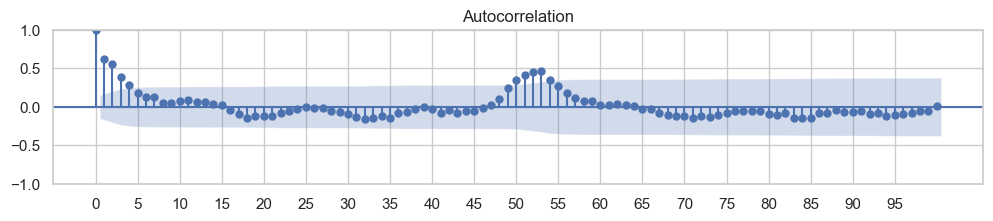

In [297]:
plt.rc('figure', figsize=(12,2))
plot_acf(data_train, lags=100)
plt.xticks(range(0,100,5))
plt.grid(True)

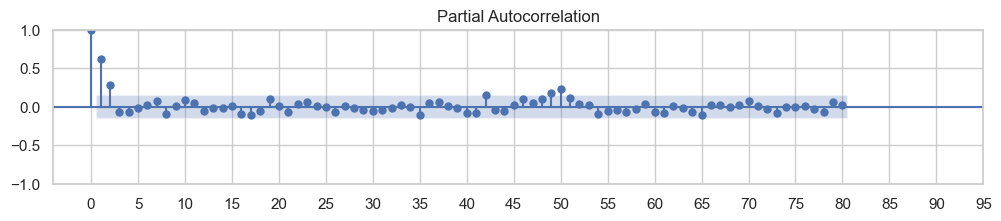

In [299]:
plt.rc('figure', figsize=(12,2))
plot_pacf(data_train, lags=80)
plt.xticks(range(0,100,5))
plt.grid(True)

El grafico autocorrelacion y autocorrelación parcial sugieren que los valores de q=2 (media movil) y el de p=3(terminos autorregresivos) respectivamente. comenzaremos el analisis de con estos valores y luego iremos ajustando.

MAPE promedio: 0.27
MAE promedio: 51.61
RMSE promedio: 67.68


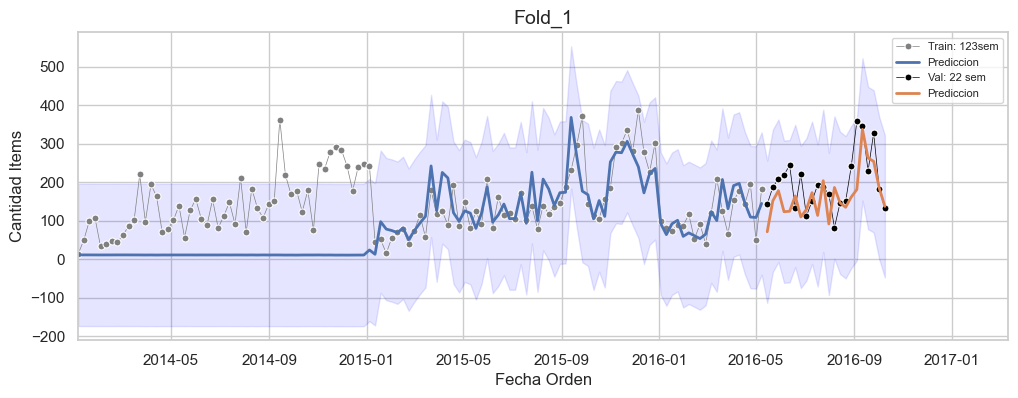

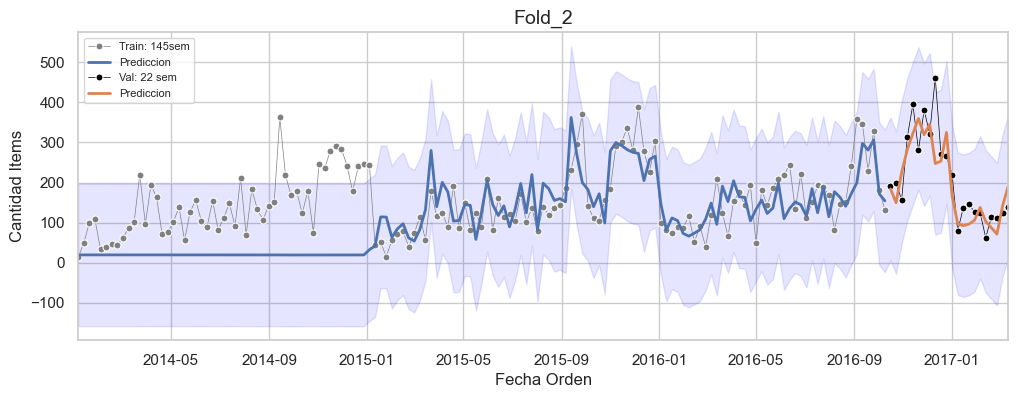

In [322]:
# Modelo ARIMA
train=data_train.copy()
metric_1=[]
metric_2=[]
metric_3=[]
i=0

for tra, val in tscv.split(train):
        # datos de entrenamiento y validación
        y_train=train.iloc[tra]
        y_val=train.iloc[val]
        
        modelo = ARIMA(order=(3, 0, 2), seasonal_order=(1, 1, 1, 52))
        modelo.fit(y_train)
        # Predicciones
        y_pred = modelo.predict(len(y_val))
        y_ajus=modelo.fittedvalues()
        serie_ajus=pd.concat([y_ajus,y_pred])
        
    # calculamos la desviacion estandar de los residuos
        int_infer=serie_ajus-np.std(y_train-pd.concat([y_ajus,y_pred]))*1.96 # Intervalo de confianza de 0.95, z-score=1.96
        int_sup=serie_ajus+np.std(y_train-pd.concat([y_ajus,y_pred]))*1.96 
        #Metricas
        MAPE= metrics.mean_absolute_percentage_error(y_val, y_pred)
        MAE=metrics.mean_absolute_error(y_val, y_pred)
        RMSE=np.sqrt(metrics.mean_squared_error(y_val, y_pred))
        R2=metrics.r2_score(y_val, y_pred)
        metric_1.append(MAPE)
        metric_2.append(MAE)
        metric_3.append(RMSE)
        i=i+1
        
        plt.figure(figsize=(12,4))
        sns.lineplot(x=y_train.index, y=y_train , data=y_train, label=f'Train: {len(y_train)}sem',color='gray', marker='o', markersize=5, linewidth='0.5')
        sns.lineplot(x=y_ajus.index, y=y_ajus , data=y_ajus, label='Prediccion',linewidth='2')
        sns.lineplot(x=y_val.index, y=y_val, data=y_val, label=f'Val: {len(y_val)} sem',color='black', marker='o', markersize=5, linewidth='0.5')
        sns.lineplot(x=y_pred.index, y=y_pred , data=y_pred, label='Prediccion',linewidth='2')
        plt.fill_between(serie_ajus.index,int_infer,int_sup, color='blue', alpha=0.1)
        plt.xlim(fecha_inicial, fecha_final)
        plt.title(f'Fold_{i}', fontsize=14)
        plt.legend(fontsize=8)
        plt.grid(True)
        
MAPE_prom=sum(metric_1)/len(metric_1)
MAE_prom=sum(metric_2)/len(metric_2)
RMSE_prom=sum(metric_3)/len(metric_3)


print(f'MAPE promedio: {round(MAPE_prom,2)}')
print(f'MAE promedio: {round(MAE_prom,2)}')
print(f'RMSE promedio: {round(RMSE_prom,2)}')



#### 6.4.2. Ajuste de hiperparametros
En este caso usaremos la funcion auto_rima de la libreria pmdarima de busqueda automatica de mejores parametros partiendo del analisis anterior y luego probaremos dichos hiperparametros en el modelo.

In [308]:
#ajuste de hiperparametros
model_auto=pm.auto_arima(train, start_p=0,d=1, start_q=0,
            max_p=4, max_q=4,
            start_P=0, D=1, start_Q=0, max_P=5,
            max_Q=4, m=52, seasonal=True,
            trace=True,
            error_action='ignore',
            suppress_warnings=True,
            stepwise=True)
print(model_auto.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[52]             : AIC=1382.029, Time=0.18 sec
 ARIMA(1,1,0)(1,1,0)[52]             : AIC=1326.333, Time=6.68 sec
 ARIMA(0,1,1)(0,1,1)[52]             : AIC=inf, Time=19.88 sec
 ARIMA(1,1,0)(0,1,0)[52]             : AIC=1337.769, Time=0.39 sec
 ARIMA(1,1,0)(2,1,0)[52]             : AIC=inf, Time=25.30 sec
 ARIMA(1,1,0)(1,1,1)[52]             : AIC=inf, Time=40.77 sec
 ARIMA(1,1,0)(0,1,1)[52]             : AIC=inf, Time=36.51 sec
 ARIMA(1,1,0)(2,1,1)[52]             : AIC=inf, Time=37.44 sec
 ARIMA(0,1,0)(1,1,0)[52]             : AIC=1367.661, Time=4.45 sec
 ARIMA(2,1,0)(1,1,0)[52]             : AIC=1318.515, Time=10.22 sec
 ARIMA(2,1,0)(0,1,0)[52]             : AIC=1332.252, Time=1.07 sec
 ARIMA(2,1,0)(2,1,0)[52]             : AIC=inf, Time=41.07 sec
 ARIMA(2,1,0)(1,1,1)[52]             : AIC=inf, Time=49.41 sec
 ARIMA(2,1,0)(0,1,1)[52]             : AIC=inf, Time=29.94 sec
 ARIMA(2,1,0)(2,1,1)[52]             : AIC=inf, Ti

#### 6.4.3 Modelo Prophet ajustado

In [311]:
metric_1=[]
metric_2=[]
metric_3=[]
i=0

for tra, val in tscv.split(train):
        # datos de entrenamiento y validación
        y_train=train.iloc[tra]
        y_val=train.iloc[val]
        
        modelo = ARIMA(order=(3, 1, 1), seasonal_order=(1, 1, 0, 52))
        modelo.fit(y_train)
        # Predicciones
        y_pred = modelo.predict(len(y_val))
        #Metricas
        MAPE= metrics.mean_absolute_percentage_error(y_val, y_pred)
        MAE=metrics.mean_absolute_error(y_val, y_pred)
        RMSE=np.sqrt(metrics.mean_squared_error(y_val, y_pred))
        metric_1.append(MAPE)
        metric_2.append(MAE)
        metric_3.append(RMSE)
        
MAPE_prom=sum(metric_1)/len(metric_1)
MAE_prom=sum(metric_2)/len(metric_2)
RMSE_prom=sum(metric_3)/len(metric_3)

metricas.loc['MAPE','ARIMA']=MAPE_prom
metricas.loc['MAE','ARIMA']=MAE_prom
metricas.loc['RMSE','ARIMA']=RMSE_prom

print(f'MAPE promedio: {round(MAPE_prom,2)}')
print(f'MAE promedio: {round(MAE_prom,2)}')
print(f'RMSE promedio: {round(RMSE_prom,2)}')


MAPE promedio: 0.28
MAE promedio: 49.46
RMSE promedio: 63.56


### 6.5. Random Forest

#### 6.5.1. Entrenamiento y predicciones

In [324]:
df=ventas_sem.copy()
df['año']=df.index.year
df['mes']=df.index.month
df['lag_1']=df['Cantidad Items'].shift(1)
df['lag_2']=df['Cantidad Items'].shift(2)
df['lag_3']=df['Cantidad Items'].shift(3)
df['lag_4']=df['Cantidad Items'].shift(4)
df['lag_5']=df['Cantidad Items'].shift(5)
df['MMA']=df['Cantidad Items'].rolling(window=5).mean().shift(1)
df.dropna(subset='lag_5', inplace=True)
# importamos el calendario festivos de estados unidos
holidays=pd.read_csv('C:/Users/horac/Proyecto Data Science/holidays_semanal_ohe.csv', index_col='Fecha')
holidays.index=pd.to_datetime(holidays.index)
holidays.drop(holidays.index[:5],inplace=True)
# agregamos una constante y tendencia
dp = DeterministicProcess(
    index=df.index,
    constant=True,
    order=1)
X_dp = dp.in_sample()

# concatenamos los datos
df=pd.concat([df,X_dp,holidays], axis=1)

#separamos la variable target de features
X=df.drop(columns='Cantidad Items')
y=df['Cantidad Items']
# conjuntos train-test
X_trainval,X_test=X[:-size],X[-size:]
y_trainval,y_test=y[:-size],y[-size:]
X_trainval.head(3)

,semana_año,semana_mes,año,mes,lag_1,lag_2,lag_3,lag_4,lag_5,MMA,...,Holiday_Labor Day,Holiday_Labor Day Weekend,"Holiday_Martin Luther King, Jr. Day",Holiday_Memorial Day,Holiday_New Year's Day,Holiday_Thanksgiving,Holiday_Valentine's Day,Holiday_Veterans Day,Holiday_Washington's Birthday,Holiday_Western Easter
2014-02-09,6,2,2014,2,33.0,108.0,99.0,49.0,13.0,60.4,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2014-02-16,7,3,2014,2,39.0,33.0,108.0,99.0,49.0,65.6,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2014-02-23,8,4,2014,2,47.0,39.0,33.0,108.0,99.0,65.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


MAPE promedio: 0.24
MAE promedio: 49.73
RMSE promedio: 67.41


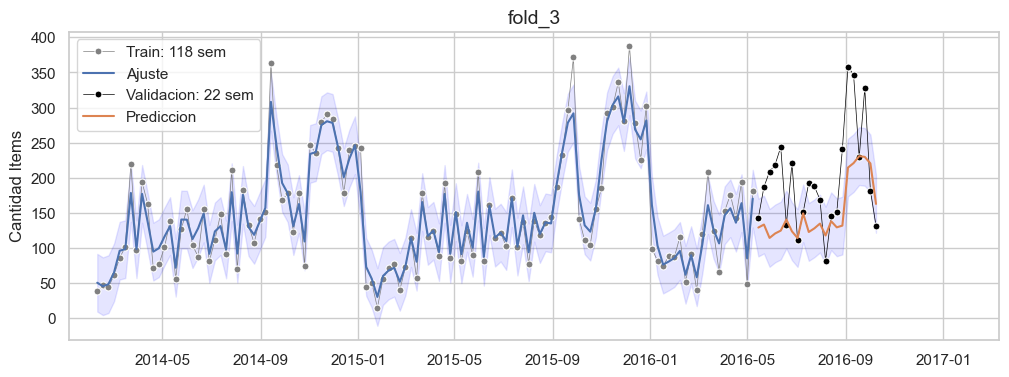

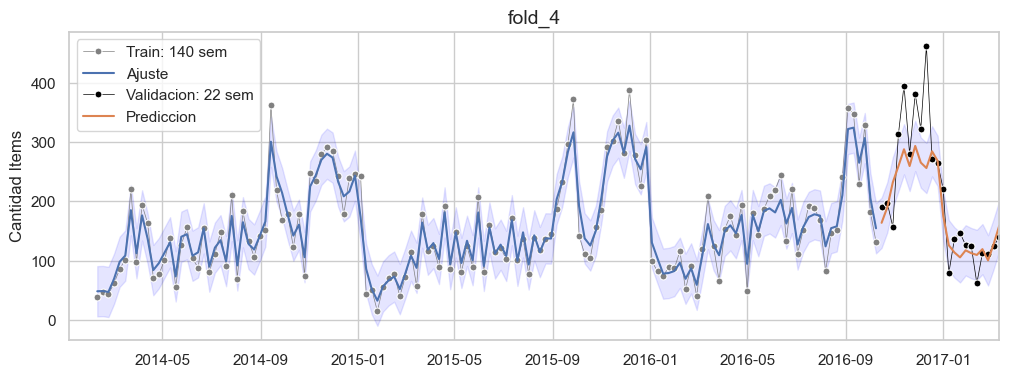

In [326]:
pmetric_1=[]
pmetric_2=[]
pmetric_3=[]

for tra, val in tscv.split(X_trainval):
    # Entrenamiento y validacion
    X_train, X_val=X_trainval.iloc[tra],X_trainval.iloc[val]
    y_train, y_val=y_trainval.iloc[tra],y_trainval.iloc[val]
    # Modelado y predicción
    model=RandomForestRegressor(random_state=123).fit(X_train,y_train)
    y_pred=pd.Series(model.predict(X_val), index=X_val.index)
    y_ajus=pd.Series(model.predict(X_train), index=X_train.index)
    serie_ajus=pd.concat([y_ajus,y_pred])
    # calculamos la desviacion estandar de los residuos
    int_infer=serie_ajus-np.std(y_train-pd.concat([y_ajus,y_pred]))*1.96 # Intervalo de confianza de 0.95, z-score=1.96
    int_sup=serie_ajus+np.std(y_train-pd.concat([y_ajus,y_pred]))*1.96 
    
    #metricas
    MAPE= mean_absolute_percentage_error(y_val, y_pred)
    MAE=mean_absolute_error(y_val, y_pred)
    RMSE=np.sqrt(metrics.mean_squared_error(y_val, y_pred))
    
    pmetric_1.append(MAPE)
    pmetric_2.append(MAE)
    pmetric_3.append(RMSE)
    i=i+1
    #graficos
    plt.figure(figsize=(12,4))
    sns.lineplot(x=y_train.index,y=y_train, data=y_train, label=f'Train: {y_train.shape[0]} sem',color='gray', marker='o', markersize=5, linewidth='0.5')
    sns.lineplot(x=y_ajus.index,y=y_ajus, data=y_ajus, label='Ajuste')
    sns.lineplot(x=y_val.index, y=y_val, data=y_val,label=f'Validacion: {y_val.shape[0]} sem',color='black', marker='o', markersize=5, linewidth='0.5')
    sns.lineplot(x=y_pred.index, y=y_pred, data=y_pred, label='Prediccion')
    plt.fill_between(serie_ajus.index,int_infer, int_sup, color='blue', alpha=0.1)
    plt.xlim(fecha_inicial, fecha_final)
    plt.title(f'fold_{i}', fontsize=14)


MAPE_prom=sum(pmetric_1)/len(pmetric_1)
MAE_prom=sum(pmetric_2)/len(pmetric_2)
RMSE_prom=sum(pmetric_3)/len(pmetric_3)
print(f'MAPE promedio: {round(MAPE_prom,2)}')
print(f'MAE promedio: {round(MAE_prom,2)}')
print(f'RMSE promedio: {round(RMSE_prom,2)}')

#### 6.5.2. Mejoras

In [327]:
#verificamos y eliminamos las variables menos relevantes
feature_importances=pd.Series(model.feature_importances_, index=X_trainval.columns)
feature_importances.sort_values(ascending=False)

mes                                    0.299752
lag_1                                  0.198193
semana_año                             0.148652
trend                                  0.089964
lag_2                                  0.055144
lag_4                                  0.050421
lag_5                                  0.048078
lag_3                                  0.041309
MMA                                    0.027363
semana_mes                             0.022482
año                                    0.004990
Holiday_Columbus Day                   0.003963
Holiday_Eastern Easter                 0.003187
Holiday_Western Easter                 0.002631
Holiday_Labor Day Weekend              0.001137
Holiday_Juneteenth                     0.001107
Holiday_Veterans Day                   0.000420
Holiday_Christmas Day                  0.000353
Holiday_Thanksgiving                   0.000203
Holiday_Labor Day                      0.000203
Holiday_Valentine's Day                0

In [328]:
X.drop(columns={'Holiday_Martin Luther King, Jr. Day','Holiday_Veterans Day',"Holiday_New Year's Day",
                 "Holiday_Washington's Birthday",'const'},inplace=True)
X_trainval,X_test=X[:-size],X[-size:]

In [219]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error
param_grid = {
    'n_estimators': [100, 200, 300,400,500],  # Número de árboles en el bosque
    'max_depth': [None, 5, 10, 15,20],   # Profundidad máxima de cada árbol
    'min_samples_split': [2, 5, 10],  # Número mínimo de muestras requeridas para dividir un nodo interno
    'min_samples_leaf': [1, 2, 4]     # Número mínimo de muestras requeridas en un nodo hoja
}
scorer = make_scorer(mean_squared_error, greater_is_better=False) #definimos la metrica porcentual para comparar
rf=RandomForestRegressor()
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=2,scoring=scorer)
grid_search.fit(X_trainval, y_trainval)
print(grid_search.best_params_)

Fitting 2 folds for each of 225 candidates, totalling 450 fits
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}


#### 6.5.3 RandomForest ajustado

In [329]:
# Reentrenamos el modelo con los hiperparametros mejorado
metric_1=[]
metric_2=[]
metric_3=[]

for tra, val in tscv.split(X_trainval):
    # Entrenamiento y validacion
    X_train, X_val=X_trainval.iloc[tra],X_trainval.iloc[val]
    y_train, y_val=y_trainval.iloc[tra],y_trainval.iloc[val]
    # Modelado y predicción
    model=RandomForestRegressor(random_state=123,max_depth= None, min_samples_leaf= 2, min_samples_split= 2, n_estimators= 300
    ).fit(X_train,y_train)
    y_pred=pd.Series(model.predict(X_val), index=X_val.index)
    #metricas
    MAPE= mean_absolute_percentage_error(y_val, y_pred)
    MAE=mean_absolute_error(y_val, y_pred)
    RMSE=np.sqrt(metrics.mean_squared_error(y_val, y_pred))
    metric_1.append(MAPE)
    metric_2.append(MAE)
    metric_3.append(RMSE)


MAPE_prom=sum(metric_1)/len(metric_1)
MAE_prom=sum(metric_2)/len(metric_2)
RMSE_prom=sum(metric_3)/len(metric_3)
metricas.loc['MAPE','RandomForest']=MAPE_prom
metricas.loc['MAE','RandomForest']=MAE_prom
metricas.loc['RMSE','RandomForest']=RMSE_prom
print(f'MAPE promedio: {round(MAPE_prom,2)}')
print(f'MAE promedio: {round(MAE_prom,2)}')
print(f'RMSE promedio: {round(RMSE_prom,2)}')

MAPE promedio: 0.23
MAE promedio: 49.33
RMSE promedio: 67.08


## 7. Evaluacion de desempeño de los modelos y optimización
Para comparar el rendimiento de los modelos, emplearemos la métrica RMSE como un indicador fundamental. Además de considerar el RMSE, evaluaremos otras métricas relevantes para obtener una visión más completa y precisa de cómo se desempeñan los distintos modelos en el contexto específico de nuestro análisis.

In [388]:
metricas

,Linear,Exponencial,Prophet,ARIMA,RandomForest
MAPE,0.258247,0.266248,0.251388,0.283037,0.23305
MAE,46.390807,46.910193,45.638686,49.460054,49.332069
RMSE,61.578682,59.840361,54.385523,63.563659,67.076967


Las métricas no presentan grandes variaciones entre los distintos modelos evaluados. No obstante, es notable que el modelo Prophet destaca por su mejor rendimiento en comparación con los demás. Esta diferencia resalta la capacidad superior del modelo Prophet para capturar y predecir los patrones de los datos en comparación con las otras opciones consideradas.

## 8. Elección del modelo

### 8.1. Reentrenamiento del con el conjunto de entrenamiento y testeo

In [389]:
df=ventas_sem.reset_index()
df.drop(columns={'semana_año','semana_mes'},inplace=True)
df=df.rename(columns={'Fecha Orden':'ds', 'Cantidad Items':'y'})
df.head(2)

,ds,y
0,2014-01-05,13.0
1,2014-01-12,49.0


In [390]:
# Adecuacion de los datos para entrenamiento

#Separacion Train (80%) - Test(20%)
train,test=df[:-size],df[-size:] #Dividimos los datos de entrenamiento y validacion de los datos de test.


11:57:30 - cmdstanpy - INFO - Chain [1] start processing
11:57:30 - cmdstanpy - INFO - Chain [1] done processing


Performance en el conjunto de testeo
MAPE: 0.17
MAE: 46.47
RMSE: 57.91


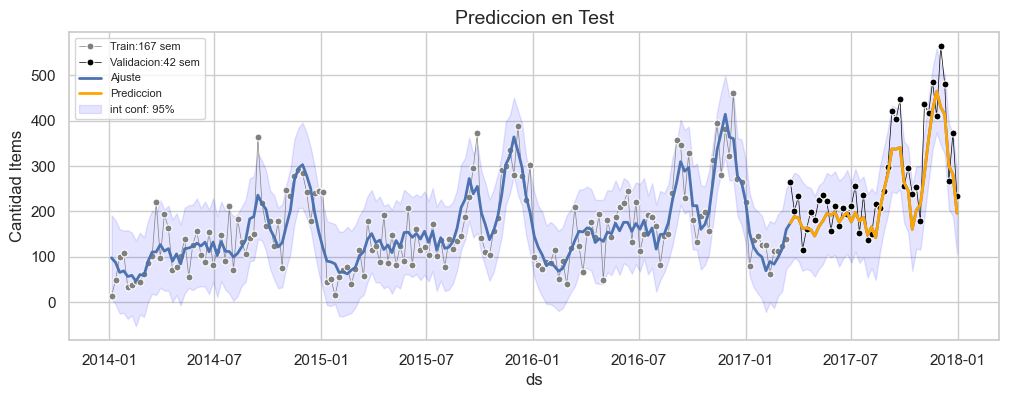

In [391]:
m=Prophet(interval_width=0.95, 
          weekly_seasonality=False,
          daily_seasonality=False,
          yearly_seasonality=6,
          changepoint_range=0.8,
          changepoint_prior_scale=0.5,
          seasonality_mode = 'multiplicative',
          n_changepoints=1)
m.add_country_holidays(country_name='US')
m.add_seasonality(name='mensual', period=4.5, fourier_order=17)
m.add_seasonality(name='cuatrimestral', period=13, fourier_order=1)
m.fit(train)

future=m.make_future_dataframe(periods=(len(test)), freq='W')
future2=m.make_future_dataframe(periods=(len(test)+4), freq='W')
forecast=m.predict(future)
forecast2=m.predict(future2)
y_pred=forecast.iloc[-len(test):][['ds','yhat']]
y_ajus=forecast.iloc[:-len(test)][['ds','yhat']]
# Metricas
MAPE= metrics.mean_absolute_percentage_error(test['y'], y_pred['yhat'])
MAE=metrics.mean_absolute_error(test['y'], y_pred['yhat'])
RMSE=np.sqrt(metrics.mean_squared_error(test['y'], y_pred['yhat']))

    
plt.figure(figsize=(12,4))
sns.lineplot(x='ds', y='y', data=train, label=f'Train:{train.shape[0]} sem',color='gray', marker='o', markersize=5, linewidth='0.5')
sns.lineplot(x='ds', y='y', data=test, label=f'Validacion:{test.shape[0]} sem',color='black', marker='o', markersize=5, linewidth='0.5')
sns.lineplot(x='ds', y='yhat', data=forecast, label='Ajuste',linewidth='2')
sns.lineplot(x='ds', y='yhat', data=y_pred, label='Prediccion',linewidth='2',color='orange')

plt.fill_between(forecast['ds'],forecast['yhat_lower'],forecast['yhat_upper'], color='blue', alpha=0.1,label='int conf: 95%')
plt.title('Prediccion en Test',fontsize=14)
plt.ylabel('Cantidad Items')
#plt.xlim(fecha_inicial, fecha_final)
plt.legend(fontsize=8)
plt.grid(True)

print('Performance en el conjunto de testeo')
print('====================================')
print(f'MAPE: {round(MAPE,2)}')
print(f'MAE: {round(MAE,2)}')
print(f'RMSE: {round(RMSE,2)}')


La métrica RMSE del modelo Prophet experimenta un incremento del 6%, elevándose de 54.38 en los datos de validación a 57.91 en los datos de prueba. Esta leve variación  sugiere una aceptable capacidad predictiva al predecir datos nuevos.

## 9. Predicciones
Las predicciones para las próximas 4 semanas a partir de la última fecha registrada en el dataset, que era el objetivo principal de este proyecto, se presentan a continuación. Estas predicciones representan una parte crucial del análisis, ya que ofrecen información proyectada sobre el comportamiento futuro de los datos, permitiendo así tomar decisiones fundamentadas.

In [392]:
pronostico=forecast2.iloc[-4:][['ds','yhat','yhat_lower','yhat_upper']]
pronostico

,ds,yhat,yhat_lower,yhat_upper
209,2018-01-07,170.561248,82.561416,265.527366
210,2018-01-14,131.473221,43.257195,225.738974
211,2018-01-21,133.585791,40.042639,224.636183
212,2018-01-28,114.228691,27.576722,207.951321


## 10. Conclusiones

- Las métricas de los modelos no alcanzan valores muy altos. No obstante, logramos capturar los patrones principales de las ventas.
- A pesar de nuestros esfuerzos, la inclusión de variables exógenas, como los días festivos, no mejoró significativamente las métricas de los modelos. Sería esencial explorar más a fondo los datos internos de la empresa para identificar fenómenos que puedan enriquecer nuestros modelos de ventas, como análisis de promociones, visitas a la página web y otros indicadores relevantes.
- Conseguimos predecir la cantidad de artículos que se venderán en las próximas 4 semanas. Este dato es crucial para la planificación logística y la distribución de productos, permitiéndonos anticiparnos a posibles escenarios y mantener el cumplimiento de los plazos de entrega, lo que se traduce en una mayor satisfacción de los clientes.